# NUS DSESC DATABUSTERS GROUP 11

### Libraries Installation

In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 3.6 MB/s eta 0:00:0000:0100:01
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for 

## Data Cleaning
We focused on the quarterly dataset as it provides GDP values for each quarter, enabling us to forecast GDP downturns and simulate whether the economy is in a downturn. To support this analysis, we narrowed down the variables to those with a stronger causal relationship to Y, defined as Y = C + G + I + (X − M), along with other key indicators such as the consumer sentiment index, CPI, and S&P 500 index.

In [1]:
# importing the csv files in pandas
import pandas as pd  
     
# make monthly data dataframe  
quarterly = pd.read_csv("Quarterly Data.csv")

# remove first two rows
quarterly = quarterly.drop([0, 1]).reset_index(drop=True)

# list of columns that are of interest
columns_to_keep = [
    "sasdate", 'GDPC1', 'PCECC96', 'GPDIC1', 'GCEC1', 'EXPGSC1', 'IMPGSC1',
    'VIXCLSx', 'S&P 500', 'UMCSENTx', 'CPIAUCSL', 'FEDFUNDS'
]

# create a copy of the subset
quarterly_cleaned = quarterly[columns_to_keep].copy()

# dictionary mapping old column names to new column names
new_column_names = {
    'sasdate' : 'Date',
    'GDPC1': 'GDP',
    'PCECC96': 'Real_Consumption',
    'GPDIC1': 'Real_Priv_Investment',
    'GCEC1': 'Government_Expenditure',
    'EXPGSC1': 'Exports',
    'IMPGSC1': 'Imports',
    'VIXCLSx': 'VIX',
    'S&P 500': 'S&P500',
    'UMCSENTx': 'UMC_Sentiment',
    'CPIAUCSL': 'CPI',
    'FEDFUNDS': 'Nominal_Interest_Rate'
}

# rename the columns
quarterly_cleaned.rename(columns=new_column_names, inplace=True)
quarterly_cleaned

,Date,GDP,Real_Consumption,Real_Priv_Investment,Government_Expenditure,Exports,Imports,VIX,S&P500,UMC_Sentiment,CPI,Nominal_Interest_Rate
0,3/1/1959,3352.129,2039.017,354.894,1142.671,89.697,115.440,NaN,55.5167,NaN,28.9933,2.5700
1,6/1/1959,3427.667,2070.508,382.500,1156.740,88.981,121.057,NaN,57.5067,95.3,29.0433,3.0833
2,9/1/1959,3430.057,2092.138,357.798,1166.589,97.562,122.212,NaN,58.7300,NaN,29.1933,3.5767
3,12/1/1959,3439.832,2094.495,369.442,1157.052,92.734,119.109,NaN,57.7633,93.8,29.3700,3.9900
4,3/1/1960,3517.181,2114.532,406.581,1137.363,104.686,123.608,NaN,56.2767,100.0,29.3967,3.9333
...,...,...,...,...,...,...,...,...,...,...,...,...
258,9/1/2023,22780.933,15646.695,4237.303,3836.304,2521.467,3460.391,14.9665,4458.1800,69.6,306.0343,5.2600
259,12/1/2023,22960.600,15781.367,4244.835,3870.720,2559.591,3496.290,15.2631,4471.5033,64.9,308.0990,5.3300
260,3/1/2024,23053.545,15856.867,4282.515,3887.718,2571.763,3548.749,13.6316,4999.3800,78.4,310.9897,5.3300
261,6/1/2024,23223.906,15967.266,4369.185,3917.049,2578.386,3614.047,13.9525,5254.2867,71.5,313.1603,5.3300


We also aimed to include the real interest rate in our analysis. Since it was not directly available, we calculated it using the data at hand. Specifically, we used the federal funds rate as the nominal interest rate. To derive the inflation rate, we calculated the percentage change in the consumer price index (CPI) from one period to the next. Finally, we applied the Fisher equation to compute the real interest rate.

In [3]:
# calculate real interest rate using the fisher equation

# calculate the annual inflation rate as the percentage change in CPI
quarterly_cleaned['Inflation_Rate'] = quarterly_cleaned['CPI'].pct_change() * 100

# calculate the real interest rate using the Fisher equation
quarterly_cleaned['Real_Interest_Rate'] = (1 + quarterly_cleaned['Nominal_Interest_Rate'] / 100) / (1 + quarterly_cleaned['Inflation_Rate'] / 100) - 1

# convert the real interest rate to percentage
quarterly_cleaned['Real_Interest_Rate'] *= 100
quarterly_cleaned

# create a final copy of the subset
columns_to_keep = [
    "Date", "GDP", "Real_Consumption", "Real_Priv_Investment", "Government_Expenditure", "Exports", 
    "Imports", "VIX", "S&P500", "UMC_Sentiment",  "Inflation_Rate", "Nominal_Interest_Rate", "Real_Interest_Rate"
]
quarterly_final = quarterly_cleaned[columns_to_keep].copy()
quarterly_final

# save to excel file
quarterly_final.to_csv("quarterly_final.csv")


### Percentage Change Dataset
Initially, we considered using the smaller, previously derived dataset. However, after further discussion, we decided to create a new dataset based on the cleaned `quarterly_final.csv` dataset by calculating the percentage change for each variable across periods. This approach was necessary because our dependent variable is the percentage change in GDP, making it crucial for the explanatory variables to also be expressed as percentage changes.

In [4]:
# import csv file
quarterly_perc = pd.read_csv("quarterly_final.csv")

# calculate percentage change for all variables
quarterly_perc['date'] = quarterly_perc["Date"]
quarterly_perc['gdp_change'] = quarterly_perc['GDP'].pct_change() * 100
quarterly_perc['consump_change'] = quarterly_perc['Real_Consumption'].pct_change() * 100
quarterly_perc['invest_change'] = quarterly_perc['Real_Priv_Investment'].pct_change() * 100
quarterly_perc['govt_change'] = quarterly_perc['Government_Expenditure'].pct_change() * 100
quarterly_perc['exports_change'] = quarterly_perc['Exports'].pct_change() * 100
quarterly_perc['imports_change'] = quarterly_perc['Imports'].pct_change() * 100
quarterly_perc['vix_change'] = quarterly_perc["VIX"].pct_change() * 100
quarterly_perc['sp500_change'] = quarterly_perc["S&P500"].pct_change() * 100
quarterly_perc['umc_senti_change'] = quarterly_perc["UMC_Sentiment"].pct_change() * 100
quarterly_perc['inflation_change'] = quarterly_perc['Inflation_Rate'].pct_change() * 100
quarterly_perc['nominal_int_change'] = quarterly_perc['Nominal_Interest_Rate'].pct_change() * 100
quarterly_perc['real_int_change'] = quarterly_perc['Real_Interest_Rate'].pct_change() * 100

# keep the last 12 columns and remove first 14 rows
quarterly_perc = quarterly_perc.iloc[15:, -13:]
quarterly_perc

# save to excel file
quarterly_perc.to_csv("quarterly_perc.csv")

## Descriptive Statistics
We began by creating scatter plots for all variables in `quarterly_perc.csv` against gdp_change to visualize the relationships between the independent variables and the dependent variable, `gdp_change`.

       Unnamed: 0  gdp_change  consump_change  invest_change  govt_change  \
count  248.000000  248.000000      248.000000     248.000000   248.000000   
mean   138.500000    0.737196        0.795350       1.029619     0.448869   
std     71.735626    1.065610        1.053895       3.964073     0.954111   
min     15.000000   -7.908965       -8.743142     -16.107924    -1.905642   
25%     76.750000    0.350531        0.427151      -0.738859    -0.082270   
50%    138.500000    0.756682        0.768066       0.903409     0.425862   
75%    200.250000    1.112626        1.137935       3.043659     0.915311   
max    262.000000    7.830225        9.005200      18.487304     4.438641   

       exports_change  imports_change  vix_change  sp500_change  \
count      248.000000      248.000000  248.000000    248.000000   
mean         1.331157        1.407804    2.137650      2.037135   
std          3.640556        3.577190   23.122358      5.953615   
min        -21.116772      -17.092380 

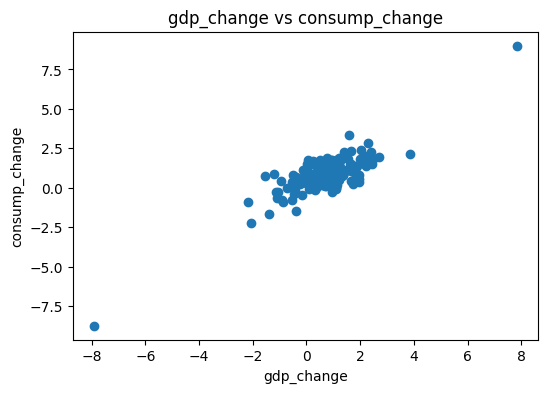

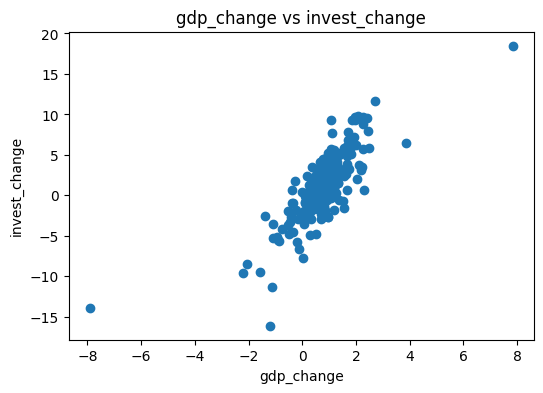

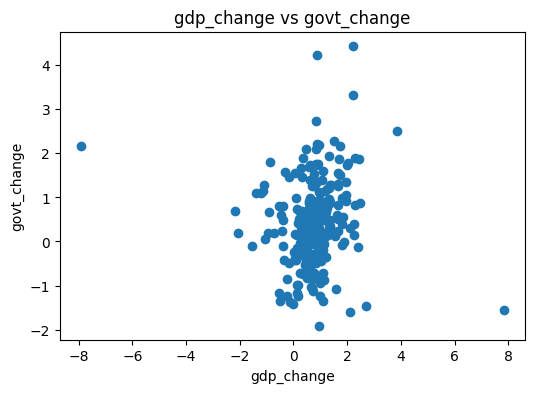

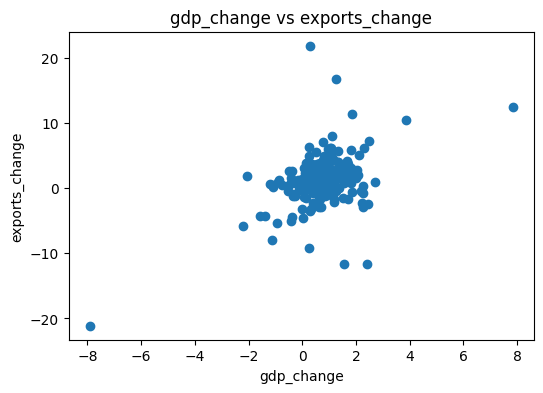

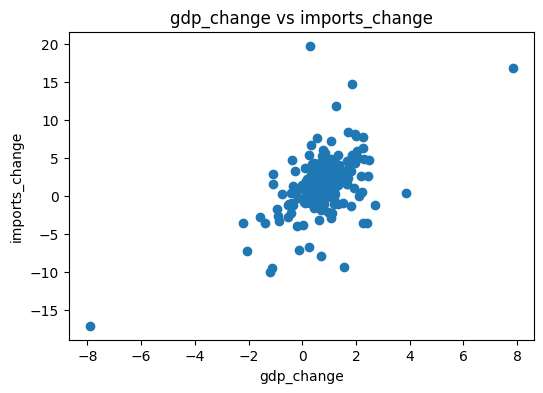

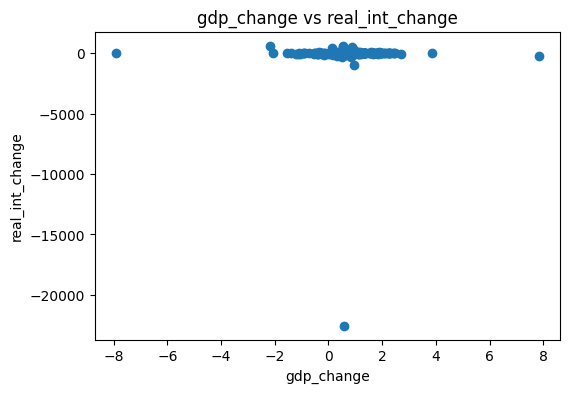

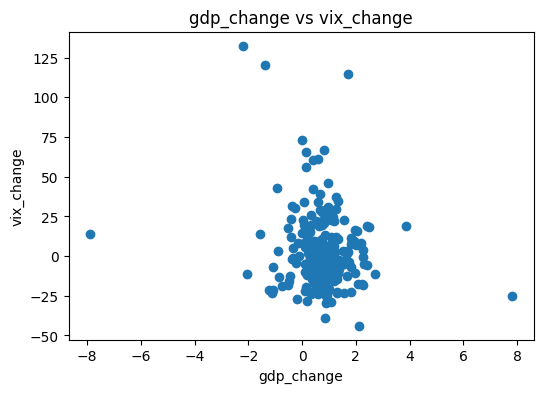

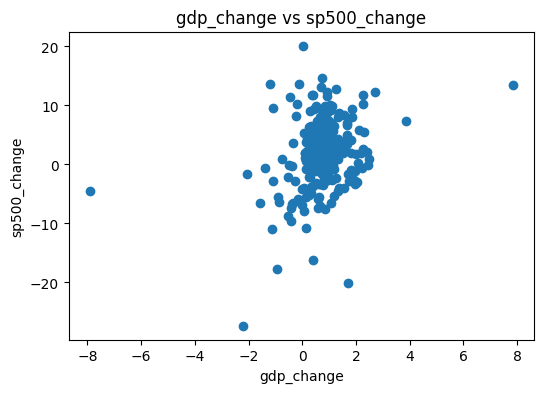

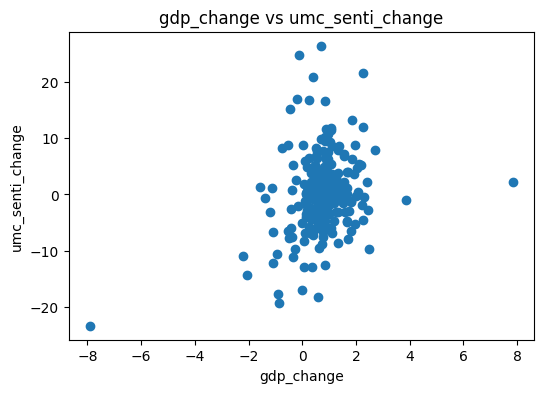

In [5]:
import pandas as pd

quarterly = pd.read_csv("quarterly_perc.csv")
descriptive_stats = quarterly.describe()
print(descriptive_stats)

import matplotlib.pyplot as plt

# list of variables (excluding 'gdp_change' itself)
variables = ['consump_change', 'invest_change', 'govt_change', 'exports_change', 
             'imports_change', 'real_int_change', 'vix_change', 'sp500_change', 'umc_senti_change']

# create scatter plots for each variable against 'gdp_change'
for var in variables:
    plt.figure(figsize=(6, 4))
    plt.scatter(quarterly['gdp_change'], quarterly[var])
    plt.title(f'gdp_change vs {var}')
    plt.ylabel(var)
    plt.xlabel('gdp_change')
    plt.show()

Next, we decided to focus on exploring the expenditure approach formula, Y = C + G + I + X - M. Notably, we used the `quarterly_final.csv` dataset to utilize the real values of the components and Y for better visualization.

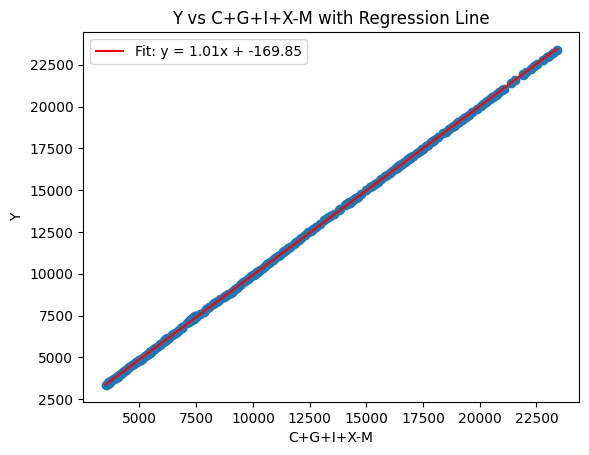

In [6]:
# create a new column with c+g+i+x-m 
quarterly_final = pd.read_csv("quarterly_final.csv")

quarterly_final["Yhat"] = quarterly_final["Real_Consumption"] + quarterly_final["Government_Expenditure"] + quarterly_final["Real_Priv_Investment"] + quarterly_final["Exports"] - quarterly_final["Imports"]
import matplotlib.pyplot as plt
import numpy as np

# scatter plot of gdp vs yhat
plt.scatter(quarterly_final["Yhat"], quarterly_final["GDP"])
slope, intercept = np.polyfit(quarterly_final["Yhat"], quarterly_final["GDP"], 1)
regression_line = slope * quarterly_final["Yhat"] + intercept
plt.plot(quarterly_final["Yhat"], regression_line, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.title('Y vs C+G+I+X-M with Regression Line')
plt.xlabel('C+G+I+X-M')
plt.ylabel('Y')
plt.legend()
plt.show()

This was followed by a plot of the real interest rate over time, with recession periods highlighted. Interestingly, we observed that the decline in the real interest rate coincided with the recession periods.

datetime64[ns]
datetime64[ns]


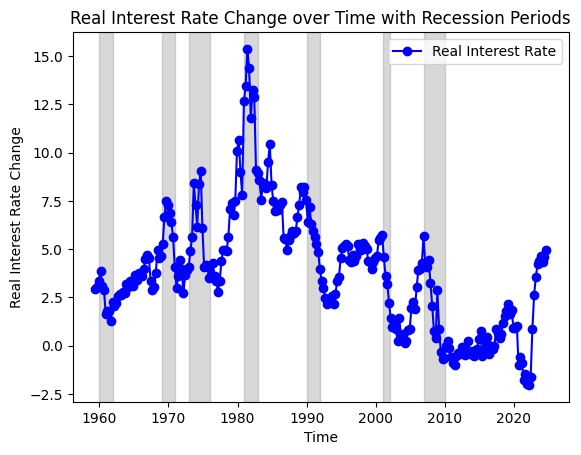

In [11]:
print(quarterly_final["Date"].dtype)

# convert date to datetime
quarterly_final['Date'] = pd.to_datetime(quarterly_final['Date'], errors='coerce')

# check the data type of the column after conversion
print(quarterly_final['Date'].dtype)

recessions = [
    (2007, 2009),  
    (2001, 2001),  
    (1990, 1991),  
    (1981, 1982),  
    (1973, 1975),  
    (1969, 1970),  
    (1960, 1961)
]
recessions_dates = [(pd.to_datetime(f'{start}-01-01'), pd.to_datetime(f'{end}-12-31')) for start, end in recessions]

plt.plot(quarterly_final['Date'], quarterly_final['Real_Interest_Rate'], marker='o', linestyle='-', color='b', label='Real Interest Rate')
for start, end in recessions_dates:
    plt.axvspan(start, end, color='gray', alpha=0.3, label='Recession Period' if start == 2007 else "")

plt.title('Real Interest Rate Change over Time with Recession Periods')
plt.xlabel('Time')
plt.ylabel('Real Interest Rate Change')
plt.legend()
plt.show()



# Models
## STATA
Our initial approach was to attempt forecasting using STATA software. However, we were unable to obtain conclusive results and only managed to generate the models. The corresponding do file and log file can be found in this repository, titled `stata_attempt.do` and `stata_attempt.log`.

## Linear Auto-Regression

In [17]:
# importing relevant functions to aid in Linear Auto-Regression Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Data Preparation

In [19]:
# extract the independent variables and format the data into the time series data needed

# importing cleaned Quarterly Data
df = pd.read_csv("quarterly_perc.csv")
# extract only the GDP data
df_working = df.iloc[:,2:]
df_working

# time series train test split
# doing a 70-30 train test split
# 248 values, 174 train and 74 test

df_train = df_working.iloc[:174]
df_test = df_working.iloc[174:]


### Linear Auto-Regression Model

A linear auto-regression (AR) model is a time series forecasting technique that predicts future values based on the past values of the same variable. It assumes that the current value of the series can be expressed as a linear combination of its previous values, with the number of past periods (lags) determined by the model.

In [20]:
# ensure df_train and df_test are dataframes with a single column
# if they are series, convert them to dataframes
if isinstance(df_train, pd.Series):
    df_train = df_train.to_frame()
if isinstance(df_test, pd.Series):
    df_test = df_test.to_frame()

# normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_scaled = scaler.fit_transform(df_train)
# test_scaled = scaler.transform(df_test)

In [21]:
collated_test_rmse= []

for j in range(1,20):

  # define sequence length (e.g., 10 time steps)
  seq_length = j

  # function to create sequences for Linear Regression
  def create_sequences(data, seq_length):
      X = []
      for i in range(len(data) - seq_length):
          X.append(data[i:i+seq_length])
      return np.array(X)

  def create_sequences_y(data, seq_length):
      y = []
      for i in range(len(data) - seq_length):
          y.append(data.iloc[i+seq_length,0])
      return np.array(y)

  # create training testing sequences for y
  y_train = create_sequences_y(df_train, seq_length)
  y_test = create_sequences_y(df_test, seq_length)

  # create training testing sequences for X
  gdp_train = create_sequences(df_train.iloc[:,0], seq_length)
  gdp_test = create_sequences(df_test.iloc[:,0], seq_length)
  consump_train = create_sequences(df_train.iloc[:,1], seq_length)
  consump_test = create_sequences(df_test.iloc[:,1], seq_length)
  invest_train = create_sequences(df_train.iloc[:,2], seq_length)
  invest_test = create_sequences(df_test.iloc[:,2], seq_length)
  govt_train = create_sequences(df_train.iloc[:,3], seq_length)
  govt_test = create_sequences(df_test.iloc[:,3], seq_length)
  exports_train = create_sequences(df_train.iloc[:,4], seq_length)
  exports_test = create_sequences(df_test.iloc[:,4], seq_length)
  imports_train = create_sequences(df_train.iloc[:,5], seq_length)
  imports_test = create_sequences(df_test.iloc[:,5], seq_length)
  vix_train = create_sequences(df_train.iloc[:,6], seq_length)
  vix_test = create_sequences(df_test.iloc[:,6], seq_length)
  sp500_train = create_sequences(df_train.iloc[:,7], seq_length)
  sp500_test = create_sequences(df_test.iloc[:,7], seq_length)
  umc_train = create_sequences(df_train.iloc[:,8], seq_length)
  umc_test = create_sequences(df_test.iloc[:,8], seq_length)
  inflation_train = create_sequences(df_train.iloc[:,9], seq_length)
  inflation_test = create_sequences(df_test.iloc[:,9], seq_length)
  nominal_train = create_sequences(df_train.iloc[:,10], seq_length)
  nominal_test = create_sequences(df_test.iloc[:,10], seq_length)
  real_train = create_sequences(df_train.iloc[:,11], seq_length)
  real_test = create_sequences(df_test.iloc[:,11], seq_length)

  X_train = np.hstack([gdp_train,consump_train,invest_train,govt_train,exports_train,imports_train,vix_train,sp500_train,umc_train,inflation_train,nominal_train,real_train])
  X_test = np.hstack([gdp_test,consump_test,invest_test,govt_test,exports_test,imports_test,vix_test,sp500_test,umc_test,inflation_test,nominal_test,real_test])

  # initialize and train the Linear Regression model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # predict on the test set
  y_pred = model.predict(X_test)
  y_test = np.array(df_test[:])

  # model performance metrics
  mae = mean_absolute_error(y_test[seq_length:,0], y_pred)
  mse = mean_squared_error(y_test[seq_length:,0], y_pred)
  rmse = np.sqrt(mse)

  print(f'Mean Absolute Error: {mae:.5f}')
  print(f'Mean Squared Error: {mse:.5f}')
  print(f'Root Mean Squared Error: {rmse:.5f}')

  collated_test_rmse.append(rmse)

print(f'Collated Root Mean Squared Error: {collated_test_rmse}')

Mean Absolute Error: 1.01463
Mean Squared Error: 7.58415
Root Mean Squared Error: 2.75393
Mean Absolute Error: 1.16417
Mean Squared Error: 8.16925
Root Mean Squared Error: 2.85819
Mean Absolute Error: 1.77921
Mean Squared Error: 22.77880
Root Mean Squared Error: 4.77271
Mean Absolute Error: 2.31126
Mean Squared Error: 45.22667
Root Mean Squared Error: 6.72508
Mean Absolute Error: 3.08957
Mean Squared Error: 59.90513
Root Mean Squared Error: 7.73984
Mean Absolute Error: 4.19458
Mean Squared Error: 94.66089
Root Mean Squared Error: 9.72938
Mean Absolute Error: 6.21216
Mean Squared Error: 227.84327
Root Mean Squared Error: 15.09448
Mean Absolute Error: 6.27631
Mean Squared Error: 194.92433
Root Mean Squared Error: 13.96153
Mean Absolute Error: 7.99121
Mean Squared Error: 365.94965
Root Mean Squared Error: 19.12981
Mean Absolute Error: 9.74905
Mean Squared Error: 482.71836
Root Mean Squared Error: 21.97085
Mean Absolute Error: 16.43401
Mean Squared Error: 1329.92286
Root Mean Squared Error

from this we can tell that the sequence of 1 achieves the lowest RMSE

In [22]:
# assuming df_train and df_test are your training and testing dataframes
# example: df_train and df_test have a single column 'GDP' with GDP values
# df_train = pd.read_csv('train.csv')  # Replace with your data loading method
# df_test = pd.read_csv('test.csv')    # Replace with your data loading method

# define sequence length
seq_length = 1

# function to create sequences for Linear Regression
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

def create_sequences_y(data, seq_length):
    y = []
    for i in range(len(data) - seq_length):
        y.append(data.iloc[i+seq_length,0])
    return np.array(y)

# create training testing sequences for y
y_train = create_sequences_y(df_train, seq_length)
y_test = create_sequences_y(df_test, seq_length)

# create training testing sequences for X
gdp_train = create_sequences(df_train.iloc[:,0], seq_length)
gdp_test = create_sequences(df_test.iloc[:,0], seq_length)
consump_train = create_sequences(df_train.iloc[:,1], seq_length)
consump_test = create_sequences(df_test.iloc[:,1], seq_length)
invest_train = create_sequences(df_train.iloc[:,2], seq_length)
invest_test = create_sequences(df_test.iloc[:,2], seq_length)
govt_train = create_sequences(df_train.iloc[:,3], seq_length)
govt_test = create_sequences(df_test.iloc[:,3], seq_length)
exports_train = create_sequences(df_train.iloc[:,4], seq_length)
exports_test = create_sequences(df_test.iloc[:,4], seq_length)
imports_train = create_sequences(df_train.iloc[:,5], seq_length)
imports_test = create_sequences(df_test.iloc[:,5], seq_length)
vix_train = create_sequences(df_train.iloc[:,6], seq_length)
vix_test = create_sequences(df_test.iloc[:,6], seq_length)
sp500_train = create_sequences(df_train.iloc[:,7], seq_length)
sp500_test = create_sequences(df_test.iloc[:,7], seq_length)
umc_train = create_sequences(df_train.iloc[:,8], seq_length)
umc_test = create_sequences(df_test.iloc[:,8], seq_length)
inflation_train = create_sequences(df_train.iloc[:,9], seq_length)
inflation_test = create_sequences(df_test.iloc[:,9], seq_length)
nominal_train = create_sequences(df_train.iloc[:,10], seq_length)
nominal_test = create_sequences(df_test.iloc[:,10], seq_length)
real_train = create_sequences(df_train.iloc[:,11], seq_length)
real_test = create_sequences(df_test.iloc[:,11], seq_length)

X_train = np.hstack([gdp_train,consump_train,invest_train,govt_train,exports_train,imports_train,vix_train,sp500_train,umc_train,inflation_train,nominal_train,real_train])
X_test = np.hstack([gdp_test,consump_test,invest_test,govt_test,exports_test,imports_test,vix_test,sp500_test,umc_test,inflation_test,nominal_test,real_test])


### Running Linear Auto-Regression using Sequence Value of 1

/var/folders/t3/4f3r77m96393n7bqz6cbqc980000gn/T/ipykernel_35579/4088627029.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'r--', label='y = 0', color='black')


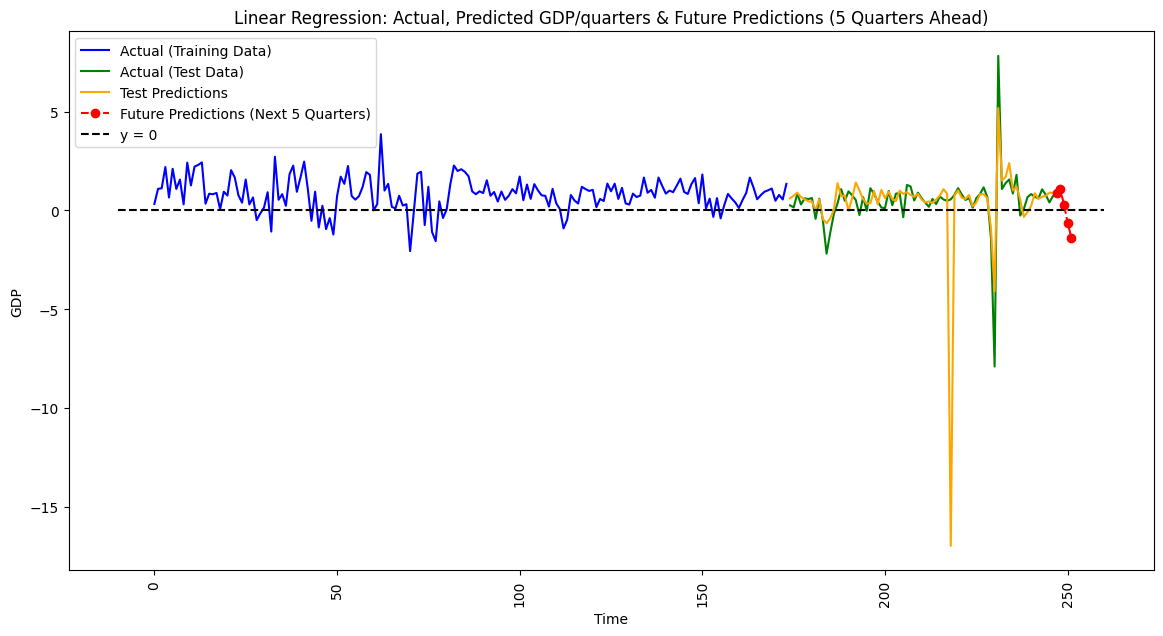

Mean Absolute Error: 1.01463
Mean Squared Error: 7.58415
Root Mean Squared Error: 2.75393


In [23]:
window = 1

# initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predict on the test set
y_pred = model.predict(X_test)
y_test = np.array(df_test[:])

# starting from the most recent sequence in the test set
last_sequence = X_test[-1].reshape((1, -1))  # Flatten the last test sequence
future_predictions = []

# loop to predict the next 5 quarters
for _ in range(5):
    # make the prediction for the next quarter
    next_prediction = model.predict(last_sequence)
    future_predictions.append(next_prediction[0])

    # update last_sequence by appending the prediction and removing the oldest value
    last_sequence = np.append(last_sequence[:, 1:], next_prediction.reshape(1, 1), axis=1)

# convert predictions into a NumPy array
future_predictions = np.array(future_predictions)

# plot the actual and predicted values (both for training and test data)
plt.figure(figsize=(14, 7))

# plot the training data
plt.plot(df_train.index, df_train.iloc[:,0], label='Actual (Training Data)', color='blue')

# plot the actual test data
plt.plot(df_test.index, y_test[:,0], label='Actual (Test Data)', color='green')

# plot test predictions
plt.plot(range(len(y_train)+window, len(y_train) + len(y_test)), y_pred, label="Test Predictions", color='orange')

# plot future predictions
future_x = np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(future_predictions))
plt.plot(future_x, future_predictions, label="Future Predictions (Next 5 Quarters)", color='red', linestyle='dashed', marker='o')

# plot y=0
x = np.linspace(-10, 260, 100)
y = np.zeros_like(x)
plt.plot(x, y, 'r--', label='y = 0', color='black')

# labels and title
plt.title('Linear Regression: Actual, Predicted GDP/quarters & Future Predictions (5 Quarters Ahead)')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.xticks(rotation=90, fontsize=10)
plt.legend()
plt.show()

# model performance metrics
r2 = r2_score(y_test[window:,0], y_pred)
mae = mean_absolute_error(y_test[seq_length:,0], y_pred)
mse = mean_squared_error(y_test[seq_length:,0], y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.5f}')
print(f'Mean Squared Error: {mse:.5f}')
print(f'Root Mean Squared Error: {rmse:.5f}')

In [ ]:
weights = model.coef_
print("model weights:", weights)

model weights: [ 1.47161625e-01  3.20791658e-01 -3.47457586e-02 -1.21387046e-01
 -2.91966786e-02  8.27679849e-02 -2.65005026e-03  3.04702372e-02
 -5.24211158e-03  9.95378977e-05 -1.55842350e-03  7.82466355e-04]


## LSTM

### Data Preparation

In [ ]:
import pandas as pd

df = pd.read_csv("quarterly_perc.csv")

# extract only the GDP data
df_working = df.iloc[:,2:]
df_working

,gdp_change,consump_change,invest_change,govt_change,exports_change,imports_change,vix_change,sp500_change,umc_senti_change,inflation_change,nominal_int_change,real_int_change
0,0.329402,1.414944,-2.925825,0.693074,-3.234702,1.222095,7.120617,3.089573,3.711790,-15.697455,2.690835,4.798808
1,1.092090,0.700486,5.261525,-1.354500,1.518745,-2.314435,-29.099762,9.952413,3.578947,31.605300,1.484624,-1.307463
2,1.122414,0.943647,1.590674,0.074623,7.993618,2.354289,-11.791203,6.285278,-6.808943,-41.654175,-0.114605,5.016682
3,2.198831,1.356577,3.078791,4.438641,-0.500513,2.538714,7.939488,1.861203,5.125409,229.247194,12.374717,-2.540037
4,0.655905,0.833300,1.214218,-1.033565,3.908221,-0.327593,39.328535,3.250257,-2.074689,-55.654126,3.702703,17.450727
...,...,...,...,...,...,...,...,...,...,...,...,...
243,1.071523,0.631372,2.433647,1.391539,1.197286,1.143789,-8.746418,6.037654,11.717496,12.578834,5.410822,4.042180
244,0.788673,0.860706,0.177755,0.897113,1.511977,1.037426,1.981759,0.298851,-6.752874,-20.261047,1.330798,5.649267
245,0.404802,0.478412,0.887667,0.439143,0.475545,1.500419,-10.689178,11.805352,20.801233,39.067575,0.000000,-5.908110
246,0.738980,0.696222,2.023811,0.754453,0.257528,1.840029,2.354089,5.098766,-8.801020,-25.608886,0.000000,5.722634


In [ ]:
# time series train test split
# doing a 70-30 train test split
# 248 values, 174 train and 74 test

df_train = df_working.iloc[:174]
df_test = df_working.iloc[174:]

### LSTM Model

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) specifically designed to address the issue of vanishing or exploding gradients as the network cycles through feedback loops. LSTMs are capable of retaining long-term dependencies in data, allowing them to better capture patterns over extended sequences.

In [ ]:
# ensure df_train and df_test are dataframes with a single column
# if they are Series, convert them to dataframes
if isinstance(df_train, pd.Series):
    df_train = df_train.to_frame()
if isinstance(df_test, pd.Series):
    df_test = df_test.to_frame()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

test_RMSE_collated = []

# iterate through for different sequence lengths to find the best amount
for i in range (5,20):

  # define sequence length
  seq_length = i

  # function to create sequences for LSTM
  def create_sequences(data, seq_length):
      X = []
      for j in range(len(data) - seq_length):
          X.append(data[j:j+seq_length])
      return np.array(X)

  def create_sequences_y(data, seq_length):
      y = []
      for j in range(len(data) - seq_length):
          y.append(data.iloc[j+seq_length,0])
      return np.array(y)


  # create training testing sequences for y
  y_train = create_sequences_y(df_train, seq_length)
  y_test = create_sequences_y(df_test, seq_length)

  # create training testing sequences for X
  gdp_train = create_sequences(df_train.iloc[:,0], seq_length)
  gdp_test = create_sequences(df_test.iloc[:,0], seq_length)
  consump_train = create_sequences(df_train.iloc[:,1], seq_length)
  consump_test = create_sequences(df_test.iloc[:,1], seq_length)
  invest_train = create_sequences(df_train.iloc[:,2], seq_length)
  invest_test = create_sequences(df_test.iloc[:,2], seq_length)
  govt_train = create_sequences(df_train.iloc[:,3], seq_length)
  govt_test = create_sequences(df_test.iloc[:,3], seq_length)
  exports_train = create_sequences(df_train.iloc[:,4], seq_length)
  exports_test = create_sequences(df_test.iloc[:,4], seq_length)
  imports_train = create_sequences(df_train.iloc[:,5], seq_length)
  imports_test = create_sequences(df_test.iloc[:,5], seq_length)
  vix_train = create_sequences(df_train.iloc[:,6], seq_length)
  vix_test = create_sequences(df_test.iloc[:,6], seq_length)
  sp500_train = create_sequences(df_train.iloc[:,7], seq_length)
  sp500_test = create_sequences(df_test.iloc[:,7], seq_length)
  umc_train = create_sequences(df_train.iloc[:,8], seq_length)
  umc_test = create_sequences(df_test.iloc[:,8], seq_length)
  inflation_train = create_sequences(df_train.iloc[:,9], seq_length)
  inflation_test = create_sequences(df_test.iloc[:,9], seq_length)
  nominal_train = create_sequences(df_train.iloc[:,10], seq_length)
  nominal_test = create_sequences(df_test.iloc[:,10], seq_length)
  real_train = create_sequences(df_train.iloc[:,11], seq_length)
  real_test = create_sequences(df_test.iloc[:,11], seq_length)

  X_train = np.hstack([gdp_train,consump_train,invest_train,govt_train,exports_train,imports_train,vix_train,sp500_train,umc_train,inflation_train,nominal_train,real_train])
  X_test = np.hstack([gdp_test,consump_test,invest_test,govt_test,exports_test,imports_test,vix_test,sp500_test,umc_test,inflation_test,nominal_test,real_test])

  # reshape input to be [samples, time steps, features]
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # build the LSTM model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1))) # 50 LSTM units
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # train the model
  model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

  # make predictions
  train_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  # evaluate the model using rmse
  from sklearn.metrics import mean_squared_error
  train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
  test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

  print(f"Window: {i}")
  print(f"Train RMSE: {train_rmse}")
  print(f"Test RMSE: {test_rmse}")

  test_RMSE_collated.append(test_rmse)

print(f"Collated Test RMSE: {test_RMSE_collated}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.5342 
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2214
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8976
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5171
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2154
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0535
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8025
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8262
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6866
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5664
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6248
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7891
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6255
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6144
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5879
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 91.5330
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 41.3304
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 17.4947
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 15.5128
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 24.6731
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.9380
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.9737
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20.7044
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.7833
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.8807
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1351
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0802
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 16.3555
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.4199
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.8864
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 534.6136
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 113.7880
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 118.6286
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 42.0083
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 85.1418
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 57.7021
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 66.7917
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 57.6670
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 61.1131
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 41.9088
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 16.2475
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18.8974
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 31.7016
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 31.8549
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 12.6157
Epoch 16/50
6/6 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 215.1878
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 12.9602
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 7.9049
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.1988
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.1060
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.5210
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2405
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.6430
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3548
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3638
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1898
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9656
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0701
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8838
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9472
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.5141
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 11.1671
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8593
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.9156
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.7777
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3647
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1657
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1695
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.9629
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7739
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6783
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7021
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6225
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4978
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5970
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 99.7590
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 25.3265
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 16.0625
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 13.6296
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 8.6599
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 11.6688
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.3213
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.5846
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.2626
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0210
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.3782
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.4551
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.4628
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.0333
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.7029
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 103.0539
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2076.7905
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1938.5779
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 345.7165
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 337.8558
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 865.9288
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 472.8923
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 376.0194
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 530.0987
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 390.8167
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1011.6651
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 488.6245
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 333.2329
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 230.7662
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 428.3529
Epoch 16/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 57.2128
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.6466
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 16.4702
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6.3846
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.4224
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.0230
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.8804
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.2084
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.1558
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.2927
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.5424
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.2688
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.8461
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.0778
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.4467
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 9.7010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.5461
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 282.7090
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.3902
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.7386
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.8000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.6486
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.8391
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.5537
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.0822
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.1769
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.1903
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.3434
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.0575
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.1076
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 6327.0103
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 249.8965
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 425.9220
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 77.1690
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 130.6755
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 315.5273
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 120.1204
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 115.9023
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 72.5267
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 46.2497
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 70.9552
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 31.8779
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 36.5255
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 26.2835
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 25.2201
Epoch 16/50
5/5 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 618.9602
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 215.3420
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 81.2554
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 33.0924
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 30.2211
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 19.6625
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 33.3209
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 41.4394
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 25.6259
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 16.1025
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 28.0124
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 16.4174
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.5408
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 21.8664
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 18.6494
Epoch 16/50
5/5 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 112.5999
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 657.1929
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 449.1652
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 621.0405
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 228.4985
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 143.4480
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 204.1517
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 129.9022
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 138.9266
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 82.1829
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 77.9112
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 86.7744
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 111.1327
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 93.5309
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 73.8578
Epoch 16/50
5/5 ━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Window: 16
Train RMSE: 4.002340591259773
Test RMSE: 70.22466735310559
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.6570
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.8731
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.9497
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.0233
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.7358
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 92.4816
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2.2300
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.8139
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.2618
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.6813
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.6836
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1660
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 1.5100
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 1.1452
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.9861
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 9.4128
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.3711
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 119.6524
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.8570
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.8416
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 8.4782
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.6913
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7260
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.5980
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.6054
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.6410
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.6522
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.5687
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.6248
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.6686
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 2081.5649
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 12.0639
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 38.3333
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 49.9507
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 60.0510
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 48.7437
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 40.0176
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 29.1374
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 15.6420
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 20.7287
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 17.3078
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 17.9780
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 15.2741
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 15.6367
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 168.0568
Epoch 16/50
5/5 ━━━━━━━━

from this we can tell that the sequence of 16 achieves the lowest rmse, albeit not as low an rmse as compared to linear auto-regression

### Running LTSM using Sequence Value of 16


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# define sequence length
seq_length = 16

# function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

def create_sequences_y(data, seq_length):
    y = []
    for i in range(len(data) - seq_length):
        y.append(data.iloc[i+seq_length,0])
    return np.array(y)


# create training testing sequences for y
y_train = create_sequences_y(df_train, seq_length)
y_test = create_sequences_y(df_test, seq_length)

# create training testing sequences for X
gdp_train = create_sequences(df_train.iloc[:,0], seq_length)
gdp_test = create_sequences(df_test.iloc[:,0], seq_length)
consump_train = create_sequences(df_train.iloc[:,1], seq_length)
consump_test = create_sequences(df_test.iloc[:,1], seq_length)
invest_train = create_sequences(df_train.iloc[:,2], seq_length)
invest_test = create_sequences(df_test.iloc[:,2], seq_length)
govt_train = create_sequences(df_train.iloc[:,3], seq_length)
govt_test = create_sequences(df_test.iloc[:,3], seq_length)
exports_train = create_sequences(df_train.iloc[:,4], seq_length)
exports_test = create_sequences(df_test.iloc[:,4], seq_length)
imports_train = create_sequences(df_train.iloc[:,5], seq_length)
imports_test = create_sequences(df_test.iloc[:,5], seq_length)
vix_train = create_sequences(df_train.iloc[:,6], seq_length)
vix_test = create_sequences(df_test.iloc[:,6], seq_length)
sp500_train = create_sequences(df_train.iloc[:,7], seq_length)
sp500_test = create_sequences(df_test.iloc[:,7], seq_length)
umc_train = create_sequences(df_train.iloc[:,8], seq_length)
umc_test = create_sequences(df_test.iloc[:,8], seq_length)
inflation_train = create_sequences(df_train.iloc[:,9], seq_length)
inflation_test = create_sequences(df_test.iloc[:,9], seq_length)
nominal_train = create_sequences(df_train.iloc[:,10], seq_length)
nominal_test = create_sequences(df_test.iloc[:,10], seq_length)
real_train = create_sequences(df_train.iloc[:,11], seq_length)
real_test = create_sequences(df_test.iloc[:,11], seq_length)

In [ ]:
X_train = np.hstack([gdp_train,consump_train,invest_train,govt_train,exports_train,imports_train,vix_train,sp500_train,umc_train,inflation_train,nominal_train,real_train])
X_test = np.hstack([gdp_test,consump_test,invest_test,govt_test,exports_test,imports_test,vix_test,sp500_test,umc_test,inflation_test,nominal_test,real_test])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# reshape input to be [samples, time steps, features] (required for LSTM)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))  # 50 LSTM units
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# evaluate the model (e.g., using Mean Squared Error)
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

# predict future GDP values
future_steps = 5  # Number of future steps to predict
last_sequence = X_test[-1]  # Last sequence from the test data
future_predictions = []

for _ in range(future_steps):
    next_prediction = model.predict(last_sequence.reshape(1, 192, 1))
    future_predictions.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], next_prediction).reshape(192, 1)

print("Future GDP Predictions:")
print(future_predictions)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 28786526.0000
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 39577676.0000
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1530757.1250
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3200617.2500
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 20628240.0000
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1053601.7500
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1028607.5000
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 448171.9688
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1145857.1250
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 383236.6875
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 144619.3594
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 394958.9375
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 63832.8477
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 350099.3750
Epoch 15/100
5/5 

<ipython-input-32-1b84e97c8a4d>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, y, 'r--', label='y = 0', color='black')


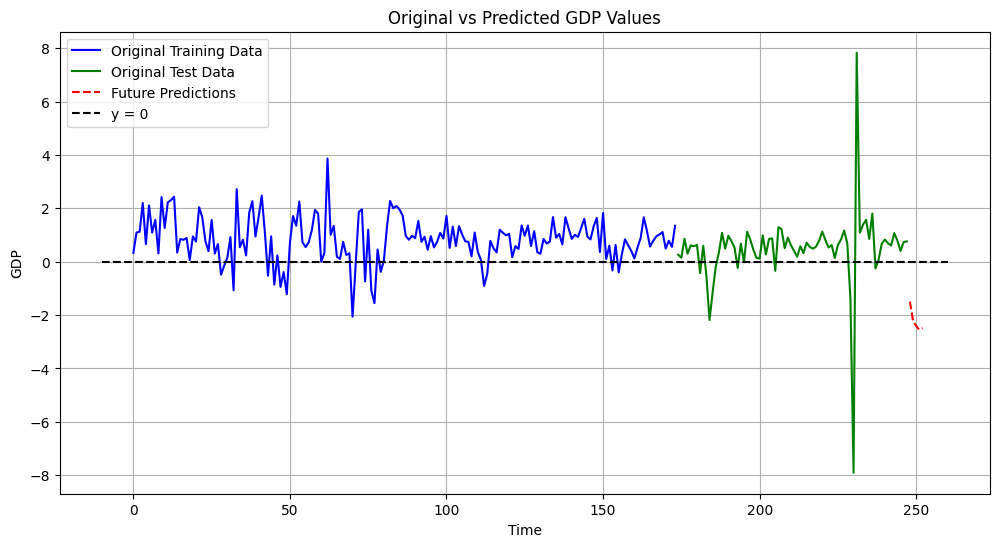

In [ ]:
import matplotlib.pyplot as plt

train_original = df_train.iloc[:,0]

# original test data
test_original = df_test.iloc[:,0]

# create a time axis for plotting
time_train = np.arange(len(train_original))
time_test = np.arange(len(train_original), len(train_original) + len(test_original))
time_future = np.arange(len(train_original) + len(test_original), len(train_original) + len(test_original) + future_steps)

# plot the original training data
plt.figure(figsize=(12, 6))
plt.plot(time_train, train_original, label='Original Training Data', color='blue')

# plot the original test data
plt.plot(time_test, test_original, label='Original Test Data', color='green')

# plot the future predictions
plt.plot(time_future, future_predictions, label='Future Predictions', color='red', linestyle='--')

# plot y=0
x = np.linspace(-10, 260, 100)
y = np.zeros_like(x)
plt.plot(x, y, 'r--', label='y = 0', color='black')

# add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('GDP')
plt.title('Original vs Predicted GDP Values')
plt.legend()
plt.grid(True)
plt.show()